<a href="https://colab.research.google.com/github/karintou8710/zero-deep-learning/blob/main/deep_learning_from_the_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

誤差伝搬法が成功しない、原因不明

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import OrderedDict

# 活性化関数

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y


# 損失関数

def mean_squared_error(y, t):
    return np.sum((y-t)**2) * 0.5

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# 勾配計算

def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

# util

def img_show(img, label):
    plt.imshow(img, cmap="gray")
    plt.title(label)
    plt.show()

def get_data():
    digit=load_digits()
    data = digit.data
    target = np.eye(10)[digit.target]

    return train_test_split(data, target, test_size=0.33, random_state=42)

In [ ]:
# 層の実装

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


In [ ]:
class TwoLayerNet:
    # パラメータの初期化
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    # 順伝播    
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)        
        return y

    # ロス計算
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    # 精度計算
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # -----------------  勾配計算  -------------------
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
        return grads


In [ ]:
# main

net = TwoLayerNet(input_size=64, hidden_size=50, output_size=10)
X_train, X_test, y_train, y_test = get_data()

iters_num = 10000
batch_size = 100
learning_rate = 0.1
train_size = X_train.shape[0]

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size // batch_size, 1)

for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    Y_batch = y_train[batch_mask]

    grads = net.gradient(X_batch, Y_batch)

    for k, v in grads.items():
        net.params[k] -= learning_rate * v
    
    loss = net.loss(X_batch, Y_batch)
    train_loss_list.append(loss)
    
    if (i % iter_per_epoch == 0):
        train_acc_list.append(net.accuracy(X_batch, Y_batch))
        test_acc_list.append(net.accuracy(X_test, y_test))
        

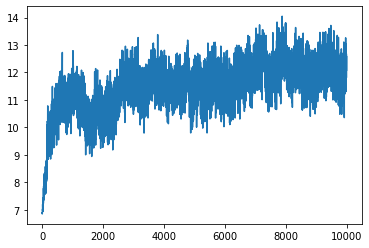

In [ ]:
plt.plot(train_loss_list)
plt.show()

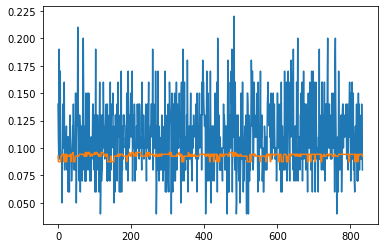

In [ ]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)